# Setup

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import gpytorch
import math
import seaborn as sns
import random
from tqdm import trange
from collections import Counter
from scipy.interpolate import splrep, interp1d
from sklearn import preprocessing
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.likelihoods import GaussianLikelihood, StudentTLikelihood
from gpytorch.models import ApproximateGP
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.mlls import ExactMarginalLogLikelihood, VariationalELBO
import matplotlib.ticker as ticker
import matplotlib.tri as tri
import matplotlib.font_manager as font_manager
from botorch.acquisition import ExpectedImprovement
from torch.distributions import Normal

# check for MPS and CUDA device availability
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device found, setting as device.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA device found, setting as device.")
else:
    device = torch.device("cpu")
    print("Neither MPS nor CUDA device found. Using default device (CPU).")


# set the seed for all random use
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)

class STP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=False
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class ExactGP(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        # build the model using the ExactGP model from gpytorch
        super(ExactGP, self).__init__(x_train, y_train, likelihood)

        # use a constant mean, this value can be learned from the dataset
        self.mean_module = gpytorch.means.ConstantMean()

        # automatically determine the number of dimensions for the ARD kernel
        num_dimensions = x_train.shape[1]

        # use a scaled Matern kernel, the ScaleKernel allows the kernel to learn a scale factor for the dataset
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5,ard_num_dims=num_dimensions))
            
        # set the number of outputs 
        self.num_outputs = 1

    def forward(self, x):
        # forward pass of the model

        # compute the mean and covariance of the model 
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        # return the MultivariateNormal distribution of the mean and covariance 
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class VariationalGP(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(VariationalGP, self).__init__(variational_strategy)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=inducing_points.size(1)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
class TorchStandardScaler:
    def fit(self, x):
        x = x.clone()
        # calculate mean and std of the tensor
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
    def transform(self, x):
        x = x.clone()
        # standardize the tensor
        x -= self.mean
        x /= (self.std + 1e-10)
        return x
    def fit_transform(self, x):
        # copy the tensor as to not modify the original 
        x = x.clone()
        # calculate mean and std of the tensor
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
        # standardize the tensor
        x -= self.mean
        x /= (self.std + 1e-10)
        return x
    
class TorchNormalizer:
    def fit(self, x):
        # calculate the maximum value and the minimum value of the tensor
        self.max = torch.max(x, dim=0).values
        self.min = torch.min(x, dim=0).values

    def transform(self, x):
        # normalize the tensor
        return (x.clone() - self.min) / (self.max - self.min)

    def fit_transform(self, x):
        # calculate the maximum value and the minimum value of the tensor
        self.max = torch.max(x, dim=0).values
        self.min = torch.min(x, dim=0).values
        # normalize the tensor
        return (x.clone() - self.min) / (self.max - self.min)

def EI(y_pred, y_std, best, maximize=True):
    if maximize:
        z = (y_pred - best) / y_std
    else:
        z = (best - y_pred) / y_std

    standard_normal = Normal(0, 1)
    ei = (y_pred - best) * standard_normal.cdf(z) + y_std * standard_normal.log_prob(z).exp()

    if not maximize:
        ei = -ei

    return ei

# Initial setup
campaigns = 1
num_initial_points = 5
num_new_samples_per_iteration = 1

maxDatasets = ['AutoAM']
minDatasets = ['Perovskite']

CUDA device found, setting as device.


# STP BO Loop

In [56]:

def runMinSTP(seed):  
    print("Minimizing with STP") 
    set_seeds(seed)
    iterationSTP = [0]
    topSTP = [0]

    bottom_5_percent_threshold = torch.quantile(train_y, 0.05)

    # Identify indices of samples not in the bottom 5%
    bottom_5_indices = (train_y <= bottom_5_percent_threshold).nonzero(as_tuple=True)[0]

    # Randomly sample from these non-bottom-5% indices
    indicesSTP = torch.randperm(len(bottom_5_indices))[:num_initial_points]
    indicesSTP = bottom_5_indices[indicesSTP]

    print(f"indices of bottom 5%: {bottom_5_indices}")

    # Select the corresponding points from train_x and train_y
    train_xSTP = train_x[indicesSTP]
    train_ySTP = train_y[indicesSTP]

    print(f"Seed: {seed}")
    print(f"Initial points: {train_xSTP}")
        
    while topSTP[-1] < 100:
        iterationSTP.append(iterationSTP[-1] + 1)
        # standardize the initial inputs and outputs before
        train_xSTP = TorchStd.transform(train_xSTP)
        train_ySTP = TorchStandardScaler().fit_transform(train_ySTP).flatten() # Ensure y is 1-dimensional

        #def train_and_test_approximate_gp(objective_function_cls):
        model = STP(train_xSTP).to(dtype=torch.float64)
        #likelihood = gpytorch.likelihoods.GaussianLikelihood()
        likelihood = gpytorch.likelihoods.StudentTLikelihood()
        objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_ySTP.numel())
        # replace with gpytorch mll
        optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

            

        # Train
        model.train()
        #put it into training mode
        likelihood.train()

        for _ in range(50):
            optimizer.zero_grad()
            output = model(train_xSTP)
            loss = -objective_function(output, train_ySTP)
            loss.backward()
            optimizer.step()
                


        # Test
        model.eval()
        likelihood.eval()

        samples = pred.sample()
        stdSTP = samples.std(dim=0)
        best = train_ySTP.max()

        acq_values = EI(samples, stdSTP, best)
        acq_valuesMean = acq_values.mean(dim=0)
        acq_valuesMean[indicesSTP] = -float('inf')
        indicesSTP = torch.cat([indicesSTP, acq_valuesMean.argmax().unsqueeze(0)])
        # find the index of the largest acquisition value and add it to the indices
        train_xSTP = train_x[indicesSTP]
        train_ySTP = train_y[indicesSTP]
        
        # Convert new_indices to a tensor
        # Add the new points to the training data
        train_xSTP = train_x[indicesSTP]
        train_ySTP = train_y[indicesSTP]
        topSTP.append(TopSamplesAmnt(train_ySTP, top_samples)*100)


        if iterationSTP[-1] > len(train_x) - num_initial_points:
            print("Maximum number of iterations exceeded, breaking loop.")
            return topSTP, iterationSTP
            break
            
    print(f'Iterations {iterationSTP[-1]}')
    return topSTP, iterationSTP

def runMaxSTP(seed):   
    print("Maximizing with STP")
    set_seeds(seed)
    iterationSTP = [0]
    topSTP = [0]

    # Calculate the threshold for the top 5%
    top_5_percent_threshold = torch.quantile(train_y, 0.95)

    # Identify indices of samples not in the top 5%
    non_top_5_indices = (train_y < top_5_percent_threshold).nonzero(as_tuple=True)[0]

    # Randomly sample from these non-top-5% indices
    indicesSTP = torch.randperm(len(non_top_5_indices))[:num_initial_points]
    indicesSTP = non_top_5_indices[indicesSTP]

    

    # Select the corresponding points from train_x and train_y
    train_xSTP = train_x[indicesSTP]
    train_ySTP = train_y[indicesSTP]

    print(f"Seed: {seed}")
    print(f"Initial points: {train_xSTP}")
        
    while topSTP[-1] < 100:
        iterationSTP.append(iterationSTP[-1] + 1)
        # standardize the initial inputs and outputs before
        train_xSTP = TorchStd.transform(train_xSTP)
        train_ySTP = TorchStandardScaler().fit_transform(train_ySTP).flatten() # Ensure y is 1-dimensional

        #def train_and_test_approximate_gp(objective_function_cls):
        model = STP(train_xSTP).to(dtype=torch.float64)
        #likelihood = gpytorch.likelihoods.GaussianLikelihood()
        likelihood = gpytorch.likelihoods.StudentTLikelihood()
        objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_ySTP.numel())
        # replace with gpytorch mll
        optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

            

        # Train
        model.train()
        #put it into training mode
        likelihood.train()

        for _ in range(50):
            optimizer.zero_grad()
            output = model(train_xSTP)
            loss = -objective_function(output, train_ySTP)
            loss.backward()
            optimizer.step()
            
                


        # Test
        model.eval()
        likelihood.eval()

        with gpytorch.settings.num_likelihood_samples(512):
            pred = likelihood(model(train_x))

        samples = pred.sample()
        stdSTP = samples.std(dim=0)
        best = train_ySTP.max()

        acq_values = EI(samples, stdSTP, best)
        acq_valuesMean = acq_values.mean(dim=0)
        acq_valuesMean[indicesSTP] = -float('inf')
        indicesSTP = torch.cat([indicesSTP, acq_valuesMean.argmax().unsqueeze(0)])
        # find the index of the largest acquisition value and add it to the indices
        train_xSTP = train_x[indicesSTP]
        train_ySTP = train_y[indicesSTP]

        topSTP.append(TopSamplesAmnt(train_ySTP, top_samples)*100)

        if iterationSTP[-1] > len(train_x) - num_initial_points:
            print("Maximum number of iterations exceeded, breaking loop.")
            print(f"Reached {topSTP[-1]}%")
            return topSTP, iterationSTP
            break


    print(f'Iterations {iterationSTP[-1]}')

    return topSTP, iterationSTP

# EGP BO Loop

In [57]:

def runMinEGP(seed):
    print("Minimizing with EGP")
    set_seeds(seed)    
    iterationEGP = [0]
    topEGP = [0]

    indicesEGP = torch.randperm(total_samples)[:num_initial_points]

    N = len(train_y) # Number of points you want to sample

    bottom_5_percent_threshold = torch.quantile(train_y, 0.05)

    # Calculate the threshold for the bottom 5%
    bottom_5_indices = (train_y <= bottom_5_percent_threshold).nonzero(as_tuple=True)[0]

    # Identify indices of samples not in the bottom 5%
    bottom_5_indices = (train_y <= bottom_5_percent_threshold).nonzero(as_tuple=True)[0]

    # Randomly sample from these non-bottom-5% indices
    indicesEGP = torch.randperm(len(bottom_5_indices))[:num_initial_points]
    indicesEGP = bottom_5_indices[indicesEGP]

    # Select the corresponding points from train_x and train_y
    train_xEGP = train_x[indicesEGP]
    train_yEGP = train_y[indicesEGP]

    print(f"Seed: {seed}")
    print(f"Initial points: {train_xEGP}")
    
    iterationEGP = [0]
    while topEGP[-1] < 100:
        iterationEGP.append(iterationEGP[-1] + 1)
        # standardize the initial inputs and outputs before
        train_xEGP = TorchStd.transform(train_xEGP)
        train_yEGP = TorchStandardScaler().fit_transform(train_yEGP).flatten()


        # optimize the model
        # use a half normal prior for the noise to find a Gaussian likelihood
        likelihood = GaussianLikelihood(noise_prior=gpytorch.priors.HalfNormalPrior(0.01))

        # using the found likelihood, create a GP model
        gp = ExactGP(train_xEGP, train_yEGP, likelihood)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

        # fit the model by maximizing the marginal log likelihood
        gp.train()
        likelihood.train()
        fit_gpytorch_mll(mll)

        gp.eval()
        likelihood.eval()

        # predict from candidate pool
        with torch.no_grad():
            pred = gp(TorchStd.transform(train_x)) # predict values for all candidates

        meanEGP = pred.mean
        stdEGP = pred.stddev
        best_observed = train_y.min().item()
        

        # pass the predictions through an acquisition function to find the next best point to sample
        acq_values = EI(meanEGP, stdEGP, best_observed)
        acq_values[indicesEGP] = -float('inf')
        indicesEGP = torch.cat([indicesEGP, acq_values.argmax().unsqueeze(0)])
        

        # add the new point to the training data
        train_xEGP = train_x[indicesEGP]
        train_yEGP = train_y[indicesEGP]
        topEGP.append(TopSamplesAmnt(train_yEGP, top_samples)*100)
        
        if iterationEGP[-1] > len(train_x) - num_initial_points:
            print("Maximum number of iterations exceeded, breaking loop.")
            return topEGP, iterationEGP
            break

    print(f'Iterations {iterationEGP[-1]}')
    return topEGP, iterationEGP

def runMaxEGP(seed):
    print("Maximizing with EGP")
    set_seeds(seed)    
    iterationEGP = [0]
    topEGP = [0]
        # Assuming train_x and train_y are your datasets
    N = len(train_y) # Number of points you want to sample

    # Calculate the threshold for the top 5%
    top_5_percent_threshold = torch.quantile(train_y, 0.95)

    # Identify indices of samples not in the top 5%
    non_top_5_indices = (train_y < top_5_percent_threshold).nonzero(as_tuple=True)[0]

    # Randomly sample from these non-top-5% indices
    indicesEGP = torch.randperm(len(non_top_5_indices))[:num_initial_points]
    indicesEGP = non_top_5_indices[indicesEGP]

    # Select the corresponding points from train_x and train_y
    train_xEGP = train_x[indicesEGP]
    train_yEGP = train_y[indicesEGP]

    print(f"Seed: {seed}")
    print(f"Initial points: {train_xEGP}")

    while topEGP[-1] < 100:
        iterationEGP.append(iterationEGP[-1] + 1)
        # standardize the initial inputs and outputs before
        train_xEGP = TorchStd.transform(train_xEGP)
        train_yEGP = TorchStandardScaler().fit_transform(train_yEGP).flatten()

        # optimize the model
        # use a half normal prior for the noise to find a Gaussian likelihood
        likelihood = GaussianLikelihood(noise_prior=gpytorch.priors.HalfNormalPrior(0.01))

        # using the found likelihood, create a GP model
        gp = ExactGP(train_xEGP, train_yEGP, likelihood)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

        # fit the model by maximizing the marginal log likelihood
        gp.train()
        likelihood.train()
        fit_gpytorch_mll(mll)

        gp.eval()
        likelihood.eval()

        # predict from candidate pool
        with torch.no_grad():
            pred = gp(TorchStd.transform(train_x)) # predict values for all candidates

        meanEGP = pred.mean
        stdEGP = pred.stddev
        best_observed = train_y.max().item()
    

        # pass the predictions through an acquisition function to find the next best point to sample
        acq_values = ExpectedImprovement(meanEGP, stdEGP, best_observed)
        acq_values[indicesEGP] = -float('inf')
        indicesEGP = torch.cat([indicesEGP, acq_values.argmax().unsqueeze(0)])
        
        # add the new point to the training data
        train_xEGP = train_x[indicesEGP]
        train_yEGP = train_y[indicesEGP]
        topEGP.append(TopSamplesAmnt(train_yEGP, top_samples)*100)
        
        if iterationEGP[-1] > len(train_x) - num_initial_points:
            print(f"Reached {topEGP[-1]}%")
            print("Maximum number of iterations exceeded, breaking loop.")
            return topEGP, iterationEGP
            break

    
    print(f'Iterations {iterationEGP[-1]}')

    return topEGP, iterationEGP

# VGP BO Loop

In [58]:

def runMinVGP(seed):    
    print("Minimizing with VGP")
    set_seeds(seed)
    iterationVGP = [0]
    topVGP = [0]

    bottom_5_percent_threshold = torch.quantile(train_y, 0.05)

    # Calculate the threshold for the bottom 5%
    bottom_5_indices = (train_y <= bottom_5_percent_threshold).nonzero(as_tuple=True)[0]

    # Identify indices of samples not in the bottom 5%
    bottom_5_indices = (train_y <= bottom_5_percent_threshold).nonzero(as_tuple=True)[0]

    # Randomly sample from these non-bottom-5% indices
    indicesVGP = torch.randperm(len(bottom_5_indices))[:num_initial_points]
    indicesVGP = bottom_5_indices[indicesVGP]

    # Select the corresponding points from train_x and train_y
    train_xVGP = train_x[indicesVGP]
    train_yVGP = train_y[indicesVGP]

    print(f"Seed: {seed}")
    print(f"Initial points: {train_xVGP}")
    
    while topVGP[-1] < 100:
        
        iterationVGP.append(iterationVGP[-1] + 1)
        # standardize the initial inputs and outputs before
        train_xVGP = TorchStd.transform(train_xVGP)
        train_yVGP = TorchStandardScaler().fit_transform(train_yVGP).flatten()

        #def train_and_test_approximate_gp(objective_function_cls):
        model = VariationalGP(train_xVGP).to(dtype=torch.float64)

        likelihood = GaussianLikelihood()
        objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_yVGP.numel())
        # replace with gpytorch mll
        optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

        # Train
        model.train()
        #put it into training mode
        likelihood.train()

        for _ in range(50):
            output = model(train_xVGP)
            loss = -objective_function(output, train_yVGP)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Test
        model.eval()
        likelihood.eval()

        # works wtih the variational distribution
        with torch.no_grad():
            pred = model(TorchStd.transform(train_x))


        # get the mean and standard deviation of the samples
        meanVGP = pred.mean
        stdVGP = pred.stddev
        best_observed = train_y.min().item()


        # Select new points using UCB
        acq_values = EI(meanVGP, stdVGP, best_observed)
        acq_values[indicesVGP] = -float('inf')
        indicesVGP = torch.cat([indicesVGP, acq_values.argmax().unsqueeze(0)])


        # Convert new_indices to a tensor
        # Add the new points to the training data
        train_xVGP = train_x[indicesVGP]
        train_yVGP = train_y[indicesVGP]
        topVGP.append(TopSamplesAmnt(train_yVGP, top_samples)*100)

        if iterationVGP[-1] > len(train_x) - num_initial_points:
            print("Maximum number of iterations exceeded, breaking loop.")
            print(f"Reached {topVGP[-1]}%")
            return topVGP, iterationVGP
            break

    
    print(f'Iterations {iterationVGP[-1]}')

    return topVGP, iterationVGP
    
def runMaxVGP(seed):   


    
    print("Maximizing with VGP") 
    set_seeds(seed)
    iterationVGP = [0]
    topVGP = [0]

    # Calculate the threshold for the top 5%
    top_5_percent_threshold = torch.quantile(train_y, 0.95)

    # Identify indices of samples not in the top 5%
    non_top_5_indices = (train_y < top_5_percent_threshold).nonzero(as_tuple=True)[0]

    # Randomly sample from these non-top-5% indices
    indicesVGP = torch.randperm(len(non_top_5_indices))[:num_initial_points]
    indicesVGP = non_top_5_indices[indicesVGP]

    # Select the corresponding points from train_x and train_y
    train_xVGP = train_x[indicesVGP]
    train_yVGP = train_y[indicesVGP]
    print(f"Seed: {seed}")
    print(f"Initial points: {train_xVGP}")
    
    
    while topVGP[-1] < 100:
        
        iterationVGP.append(iterationVGP[-1] + 1)
        # standardize the initial inputs and outputs before
        train_xVGP = TorchStd.transform(train_xVGP)
        train_yVGP = TorchStandardScaler().fit_transform(train_yVGP).flatten()

        #def train_and_test_approximate_gp(objective_function_cls):
        model = VariationalGP(train_xVGP).to(dtype=torch.float64)

        likelihood = GaussianLikelihood()
        objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_yVGP.numel())
        # replace with gpytorch mll
        optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

        # Train
        model.train()
        #put it into training mode
        likelihood.train()

        for _ in range(50):
            output = model(train_xVGP)
            loss = -objective_function(output, train_yVGP)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Test
        model.eval()
        likelihood.eval()

        # predict from candidate pool
        with torch.no_grad():
            pred = model(TorchStd.transform(train_x))

        # find the mean and standard deviation of the preidictions

        meanVGP = pred.mean
        stdVGP = pred.stddev
        best_observed = train_y.max().item()
      

        # Select new points using UCB
        acq_values = EI(meanVGP, stdVGP, best_observed)
        acq_values[indicesVGP] = -float('inf')
        indicesVGP = torch.cat([indicesVGP, acq_values.argmax().unsqueeze(0)])
        
        # Convert new_indices to a tensor
        # Add the new points to the training data
        train_xVGP = train_x[indicesVGP]
        train_yVGP = train_y[indicesVGP]
        topVGP.append(TopSamplesAmnt(train_yVGP, top_samples)*100)

        if iterationVGP[-1] > len(train_x) - num_initial_points:
            print("Maximum number of iterations exceeded, breaking loop.")
            print(f"Reached {topVGP[-1]}%")
            return topVGP, iterationVGP
            break

    print(f'Iterations {iterationVGP[-1]}')

    return topVGP, iterationVGP


In [59]:
dataset = 'P3HT'

data = pd.read_csv(f'datasets/{dataset}_dataset.csv')

data = data.groupby(data.columns[-1]).mean().reset_index()
# set train_y to the first column of the dataset
train_y = torch.tensor(data.iloc[:, 0].values, dtype=torch.float64).unsqueeze(1)
# set train_x to the remaining columns of the dataset
train_x = torch.tensor(data.iloc[:, 1:].values, dtype=torch.float64)

N = len(train_x)
data

,Conductivity (measured) (S/cm),P3HT content (%),D1 content (%),D2 content (%),D6 content (%),D8 content (%)
0,2.440000,80.26,0.53,12.03,5.47,1.78
1,2.740952,41.64,0.60,0.59,54.70,2.48
2,5.090000,88.25,0.83,8.23,1.57,1.21
3,6.190000,85.48,0.32,0.15,4.03,9.96
4,6.250000,91.13,1.99,1.95,2.24,2.69
...,...,...,...,...,...,...
225,839.280000,40.00,60.00,0.00,0.00,0.00
226,852.330000,40.00,60.00,0.00,0.00,0.00
227,904.290000,40.67,59.26,0.04,0.04,0.07
228,1089.120000,44.30,54.68,0.04,0.29,0.78


# Maximum Test

In [60]:
for element in maxDatasets:

    print(f"Starting {element}")

    dataset = element

    data = pd.read_csv(f'datasets/{dataset}_dataset.csv')
    
    data = data.groupby(data.columns[-1]).mean().reset_index()
    # set train_y to the first column of the dataset
    train_y = torch.tensor(data.iloc[:, 0].values, dtype=torch.float64).unsqueeze(1)
    # set train_x to the remaining columns of the dataset
    train_x = torch.tensor(data.iloc[:, 1:].values, dtype=torch.float64)

    N = len(train_x)

    # We are using prededfined candidates, so we can scale at the start
    TorchStd = TorchStandardScaler()
    TorchStd.fit(train_x)
    TorchNorm = TorchNormalizer()
    TorchNorm.fit(train_x)
    
    set_seeds(42)

    print(f"Number of samples: {N}")
    
    n_top = int(math.ceil(N * 0.05))

    # find the top 5% of the samples
    train_y_df = pd.DataFrame(train_y.numpy(), columns=[0])
    top_samples = train_y_df.nlargest(n_top, train_y_df.columns[0], keep='first').iloc[:, 0].values.tolist()
    
    print(f"Number of of top 5% samples: {len(top_samples)}")
    print(f"Top 5% samples: {top_samples}")
    print(f"Indices of top 5% samples: {train_y_df.nlargest(n_top, train_y_df.columns[0], keep='first').index.tolist()}")

    def TopSamplesAmnt(y, top_samples):
        return len([i for i in y if i in top_samples]) / len(top_samples)

    # Generate a list of seeds randomly picked from the range 0-1000 equal to the number of campaigns without repeating
    seedList = random.sample(range(1000), campaigns)
            
    for i in trange(len(seedList)):
        globals()['topSTP' + str(i)], globals()['iterationSTP' + str(i)] = runMaxSTP(seedList[i])

    for i in trange(len(seedList)):
        globals()['topEGP' + str(i)], globals()['iterationEGP' + str(i)] = runMaxEGP(seedList[i])

    for i in trange(len(seedList)):
        globals()['topVGP' + str(i)], globals()['iterationVGP' + str(i)] = runMaxVGP(seedList[i])


    num_arrays = len(seedList)  
    # Function to dynamically collect arrays
    def collect_arrays(prefix, num_arrays):
        arrays = []
        for i in range(num_arrays):
            array = globals().get(f'{prefix}{i}', None)
            if array is not None:
                arrays.append(array)
        return arrays

    # Function to pad arrays with the last element to match the maximum length
    def pad_array(array, max_length):
        return np.pad(array, (0, max_length - len(array)), 'constant', constant_values=array[-1])

    def find_max_length(prefix, num_arrays):
        arrays = collect_arrays(prefix, num_arrays)
        return max(len(arr) for arr in arrays)

    # Process arrays for each type
    def process_arrays(prefix, num_arrays, max_length):
        arrays = collect_arrays(prefix, num_arrays)
        padded_arrays = [pad_array(arr, max_length) for arr in arrays]
        stack = np.stack(padded_arrays)
        mean_values = np.mean(stack, axis=0)
        std_values = np.std(stack, axis=0)
        return mean_values, std_values

    # Process arrays for STP, EGP, and VGP
    max_length_STP = find_max_length('topSTP', num_arrays)
    max_length_EGP = find_max_length('topEGP', num_arrays)
    max_length_VGP = find_max_length('topVGP', num_arrays)
    max_length = max(max_length_STP, max_length_EGP, max_length_VGP)
    mean_topSTP, std_valuesSTP = process_arrays('topSTP', num_arrays, max_length)
    mean_topEGP, std_valuesEGP = process_arrays('topEGP', num_arrays, max_length)
    mean_topVGP, std_valuesVGP = process_arrays('topVGP', num_arrays, max_length)

    # Ensure that the number of iterations matches the longest array length
    max_length = max(max_length_STP, max_length_EGP, max_length_VGP)
    iterations = np.arange(1, max_length + 1)



    sns.set(style="whitegrid")
    # Plot the mean and fill between the min and max for each type
    plt.figure(figsize=(8, 6))

    # Plot for STP
    sns.lineplot(x=iterations, y=mean_topSTP, label='Mean STP', color='blue', linewidth=2)
    plt.fill_between(iterations, mean_topSTP - std_valuesSTP, mean_topSTP + std_valuesSTP, label='STP Standard Deviation', color='blue', alpha=0.1)

    # Plot for EGP
    sns.lineplot(x=iterations, y=mean_topEGP, label='Mean EGP', color='orange', linewidth=2)
    plt.fill_between(iterations, mean_topEGP - std_valuesEGP, mean_topEGP + std_valuesEGP, label='EGP Standard Deviation', color='orange', alpha=0.1)

    # Plot for VGP
    plt.plot(iterations, mean_topVGP, label='Mean VGP', color='green', linewidth=2)
    plt.fill_between(iterations, mean_topVGP - std_valuesVGP, mean_topVGP + std_valuesVGP, label='VGP Standard Deviation', color='green', alpha=0.1)

    plt.xlabel('Number of Iterations', fontsize=12)
    plt.ylabel('Percentage of Top 5% Samples Found', fontsize=12)
    plt.title(f'Average Percentage of Top Samples Found Over {num_arrays} Campaigns Using EI', fontsize=14)
    plt.legend(fontsize=10, loc='upper left')

    # Customize ticks
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Adjust axis limits and aspect ratio if needed
    plt.ylim(0, 100)
    plt.xlim(1, max_length)


    # save the plot 
    plt.savefig(f"{dataset}50Campaign50OptLoopMeanEI")
    plt.show()

data

Starting AutoAM
Number of samples: 85
Number of of top 5% samples: 5
Top 5% samples: [0.936549, 0.932613, 0.92212, 0.904846, 0.902128]
Indices of top 5% samples: [84, 83, 82, 81, 80]


  0%|          | 0/1 [00:00<?, ?it/s]

Maximizing with STP
Seed: 654
Initial points: tensor([[ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 0.0000,  3.1775, -0.2716, -0.0639],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 0.0000,  3.1974, -0.2930, -0.0577]], dtype=torch.float64)


100%|██████████| 1/1 [00:42<00:00, 42.34s/it]


Iterations 78


  0%|          | 0/1 [00:00<?, ?it/s]

Maximizing with EGP
Seed: 654
Initial points: tensor([[ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 0.0000,  3.1775, -0.2716, -0.0639],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 0.0000,  3.1974, -0.2930, -0.0577]], dtype=torch.float64)


UnsupportedError: AnalyticAcquisitionFunctions only support PosteriorTransforms.

# Minimize Test

<string>:7: SyntaxWarning: invalid escape sequence '\{'
<>:7: SyntaxWarning: invalid escape sequence '\{'
<string>:7: SyntaxWarning: invalid escape sequence '\{'
<>:7: SyntaxWarning: invalid escape sequence '\{'
C:\Users\stan\AppData\Local\Temp\ipykernel_132436\697399169.py:7: SyntaxWarning: invalid escape sequence '\{'
  data = pd.read_csv(f"datasets\{dataset}_dataset.csv")


Starting Perovskite
Number of of top 5% samples: 7
Top 5% samples: [23707.0, 24723.0, 26197.0, 27122.0, 38370.0, 38893.0, 40621.0]


  0%|          | 0/1 [00:00<?, ?it/s]

Minimizing with STP
indices of bottom 5%: tensor([0, 1, 2, 3, 4, 5, 6])
Seed: 654
Initial points: tensor([[0.3200, 0.6800, 0.0000],
        [0.1700, 0.8000, 0.0300],
        [0.1300, 0.8700, 0.0000],
        [0.2300, 0.7700, 0.0000],
        [0.1800, 0.8200, 0.0000]], dtype=torch.float64)


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Iterations 2


100%|██████████| 1/1 [00:00<00:00,  7.19it/s]


Minimizing with EGP
Seed: 654
Initial points: tensor([[0.3200, 0.6800, 0.0000],
        [0.1300, 0.8700, 0.0000],
        [0.1700, 0.8000, 0.0300],
        [0.2300, 0.7700, 0.0000],
        [0.1800, 0.8200, 0.0000]], dtype=torch.float64)
Iterations 2


  0%|          | 0/1 [00:00<?, ?it/s]

Minimizing with VGP
Seed: 654
Initial points: tensor([[0.3200, 0.6800, 0.0000],
        [0.1700, 0.8000, 0.0300],
        [0.1300, 0.8700, 0.0000],
        [0.2300, 0.7700, 0.0000],
        [0.1800, 0.8200, 0.0000]], dtype=torch.float64)


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

Iterations 2


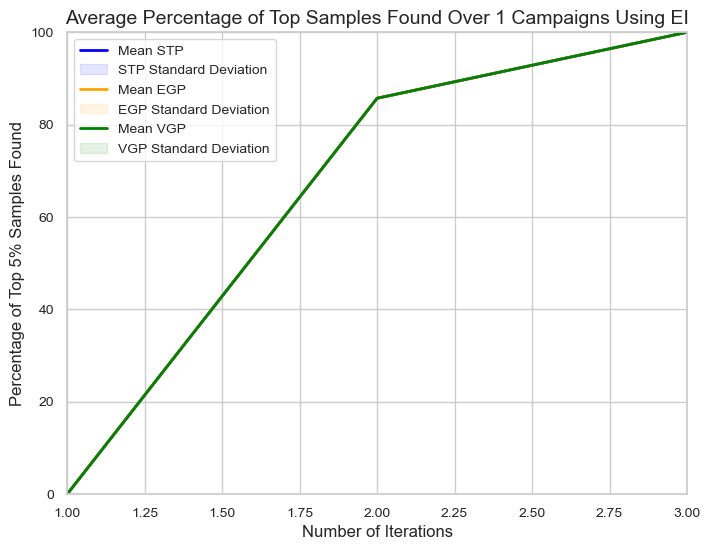

In [ ]:
for element in minDatasets:

    print(f"Starting {element}")
    
    dataset = element

    data = pd.read_csv(f"datasets\{dataset}_dataset.csv")
    data = data.groupby(data.columns[-1]).mean().reset_index()
    # set train_y to the first column of the dataset
    train_y = torch.tensor(data.iloc[:, 0].values, dtype=torch.float64).unsqueeze(1)
    # set train_x to the remaining columns of the dataset
    train_x = torch.tensor(data.iloc[:, 1:].values, dtype=torch.float64)

    N = len(train_x)

    # We are using prededfined candidates, so we can scale at the start
    TorchStd = TorchStandardScaler()
    TorchStd.fit(train_x)
    TorchNorm = TorchNormalizer()
    TorchNorm.fit(train_x)

    total_samples = len(train_y)

    set_seeds(42)

    n_top = int(math.ceil(N * 0.05))

    # find the top 5% of the samples
    train_y_df = pd.DataFrame(train_y.numpy(), columns=[0])
    top_samples = train_y_df.nsmallest(n_top, train_y_df.columns[0], keep='first').iloc[:, 0].values.tolist()
    print(f"Number of of top 5% samples: {len(top_samples)}")
    print(f"Top 5% samples: {top_samples}")

    def TopSamplesAmnt(y, top_samples):
        return len([i for i in y if i in top_samples]) / len(top_samples)

    # Generate a list of seeds randomly picked from the range 0-1000 equal to the number of campaigns without repeating
    seedList = random.sample(range(1000), campaigns)
            
    for i in trange(len(seedList)):
        globals()['topSTP' + str(i)], globals()['iterationSTP' + str(i)] = runMinSTP(seedList[i])

    for i in trange(len(seedList)):
        globals()['topEGP' + str(i)], globals()['iterationEGP' + str(i)] = runMinEGP(seedList[i])

    for i in trange(len(seedList)):
        globals()['topVGP' + str(i)], globals()['iterationVGP' + str(i)] = runMinVGP(seedList[i])


    num_arrays = len(seedList)  
    # Function to dynamically collect arrays
    def collect_arrays(prefix, num_arrays):
        arrays = []
        for i in range(num_arrays):
            array = globals().get(f'{prefix}{i}', None)
            if array is not None:
                arrays.append(array)
        return arrays

    # Function to pad arrays with the last element to match the maximum length
    def pad_array(array, max_length):
        return np.pad(array, (0, max_length - len(array)), 'constant', constant_values=array[-1])

    def find_max_length(prefix, num_arrays):
        arrays = collect_arrays(prefix, num_arrays)
        return max(len(arr) for arr in arrays)

    # Process arrays for each type
    def process_arrays(prefix, num_arrays, max_length):
        arrays = collect_arrays(prefix, num_arrays)
        padded_arrays = [pad_array(arr, max_length) for arr in arrays]
        stack = np.stack(padded_arrays)
        mean_values = np.mean(stack, axis=0)
        std_values = np.std(stack, axis=0)
        return mean_values, std_values

    # Process arrays for STP, EGP, and VGP
    max_length_STP = find_max_length('topSTP', num_arrays)
    max_length_EGP = find_max_length('topEGP', num_arrays)
    max_length_VGP = find_max_length('topVGP', num_arrays)
    max_length = max(max_length_STP, max_length_EGP, max_length_VGP)
    mean_topSTP, std_valuesSTP = process_arrays('topSTP', num_arrays, max_length)
    mean_topEGP, std_valuesEGP = process_arrays('topEGP', num_arrays, max_length)
    mean_topVGP, std_valuesVGP = process_arrays('topVGP', num_arrays, max_length)

    # Ensure that the number of iterations matches the longest array length
    max_length = max(max_length_STP, max_length_EGP, max_length_VGP)
    iterations = np.arange(1, max_length + 1)



    sns.set(style="whitegrid")
    # Plot the mean and fill between the min and max for each type
    plt.figure(figsize=(8, 6))

    # Plot for STP
    sns.lineplot(x=iterations, y=mean_topSTP, label='Mean STP', color='blue', linewidth=2)
    plt.fill_between(iterations, mean_topSTP - std_valuesSTP, mean_topSTP + std_valuesSTP, label='STP Standard Deviation', color='blue', alpha=0.1)

    # Plot for EGP
    sns.lineplot(x=iterations, y=mean_topEGP, label='Mean EGP', color='orange', linewidth=2)
    plt.fill_between(iterations, mean_topEGP - std_valuesEGP, mean_topEGP + std_valuesEGP, label='EGP Standard Deviation', color='orange', alpha=0.1)

    # Plot for VGP
    plt.plot(iterations, mean_topVGP, label='Mean VGP', color='green', linewidth=2)
    plt.fill_between(iterations, mean_topVGP - std_valuesVGP, mean_topVGP + std_valuesVGP, label='VGP Standard Deviation', color='green', alpha=0.1)

    plt.xlabel('Number of Iterations', fontsize=12)
    plt.ylabel('Percentage of Top 5% Samples Found', fontsize=12)
    plt.title(f'Average Percentage of Top Samples Found Over {num_arrays} Campaigns Using EI', fontsize=14)
    plt.legend(fontsize=10, loc='upper left')

    # Customize ticks
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Adjust axis limits and aspect ratio if needed
    plt.ylim(0, 100)
    plt.xlim(1, max_length)


    # save the plot 
    plt.savefig(f"{dataset}50Campaign50OptLoopMeanEI")
    plt.show()